<a href="https://colab.research.google.com/github/Shuvo3128/BACKBENCHER-/blob/main/Preprocess_and_ML_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn spacy nltk bs4 matplotlib seaborn wordcloud

In [ ]:
# =========================================
# Part 1: Install & Import Libraries + Load Data
# =========================================

# Install required packages
# !pip install pandas numpy scikit-learn spacy nltk bs4 matplotlib seaborn wordcloud

import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import spacy
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Download resources
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/train_data (1).csv")  # Change path
test_df = pd.read_csv("/content/drive/MyDrive/test_data (1).csv")    # Change path

# Check dataset columns
print("Train dataset columns:", train_df.columns)
print("Test dataset columns:", test_df.columns)

# Manually set column names after checking
text_col = "review"       # Change to your actual text column name
label_col = "sentiment"   # Change to your actual label column name

print(f"Using text column: {text_col}")
print(f"Using label column: {label_col}")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train dataset columns: Index(['0', '1'], dtype='object')
Test dataset columns: Index(['0', '1'], dtype='object')
Using text column: review
Using label column: sentiment


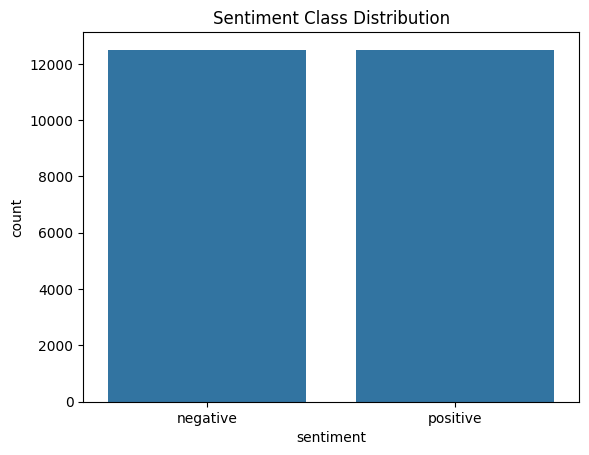

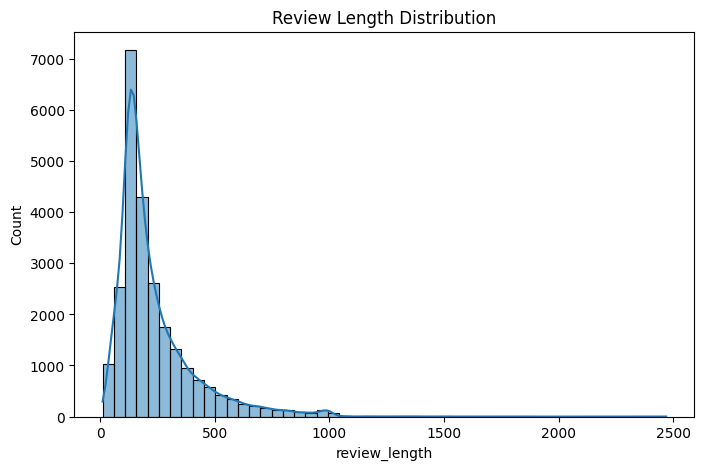

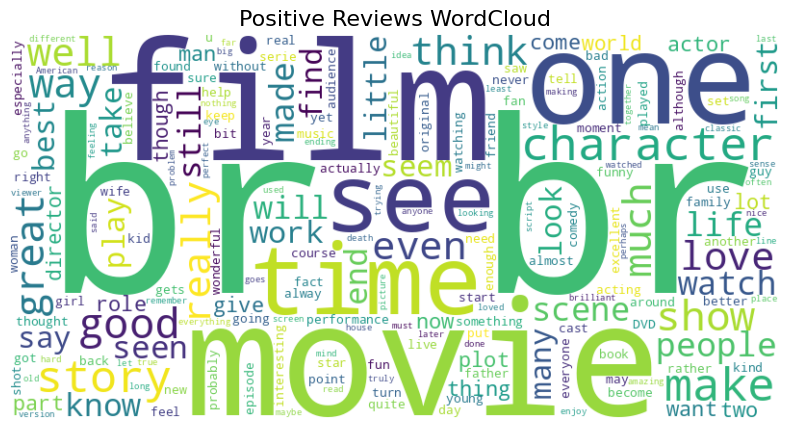

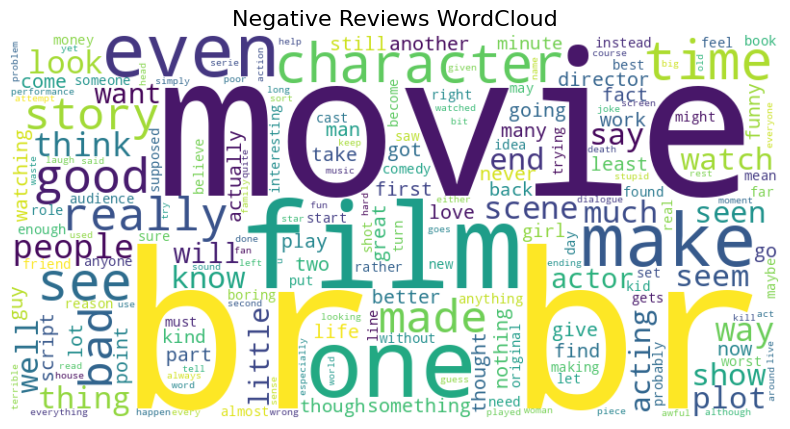

In [ ]:
# Rename columns properly
train_df.columns = ["review", "sentiment"]

# Convert sentiment to readable labels if needed
# Assuming 1 = positive, 0 = negative
train_df['sentiment'] = train_df['sentiment'].map({1: "positive", 0: "negative"})

# Now variables for plotting
text_col = "review"
label_col = "sentiment"

# Class distribution
sns.countplot(x=label_col, data=train_df)
plt.title("Sentiment Class Distribution")
plt.show()

# Review length distribution
train_df['review_length'] = train_df[text_col].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(train_df['review_length'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.show()

# Word clouds
def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

plot_wordcloud(train_df[train_df[label_col] == "positive"][text_col], "Positive Reviews WordCloud")
plot_wordcloud(train_df[train_df[label_col] == "negative"][text_col], "Negative Reviews WordCloud")


In [ ]:
# --- Mount Google Drive and setup project folder ---
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd, numpy as np
BASE_DIR = "/content/drive/MyDrive/IMDB_Project"
os.makedirs(BASE_DIR, exist_ok=True)

# --- Load datasets (update paths if needed) ---
train_df = pd.read_csv("/content/drive/MyDrive/train_data (1).csv", header=None if list(pd.read_csv("/content/drive/MyDrive/train_data (1).csv", nrows=1).columns)==[0,1] else 'infer')
test_df  = pd.read_csv("/content/drive/MyDrive/test_data (1).csv",  header=None if list(pd.read_csv("/content/drive/MyDrive/test_data (1).csv",  nrows=1).columns)==[0,1] else 'infer')

# --- Robust column inference & rename for both train and test ---
def infer_and_rename(df):
    cols = list(df.columns)
    # If column names are generic like 0,1 -> pick text as object-like and label as numeric/binary
    if len(cols) == 2 and set(cols) == {0, 1}:
        # choose text column by dtype/object-ness and average length
        obj_cols = [c for c in cols if df[c].dtype == 'object']
        if len(obj_cols) == 1:
            text_c = obj_cols[0]
            label_c = [c for c in cols if c != text_c][0]
        else:
            # fallback: column with larger average string length is text
            lens = {c: df[c].astype(str).str.len().mean() for c in cols}
            text_c = max(lens, key=lens.get)
            label_c = [c for c in cols if c != text_c][0]
        df = df.rename(columns={text_c:'review', label_c:'sentiment'})
        return df

    # If named columns exist, normalize to 'review' and 'sentiment'
    ren = {}
    for c in cols:
        cl = str(c).lower()
        if any(k in cl for k in ['review', 'text', 'content', 'sentence']):
            ren[c] = 'review'
        if any(k in cl for k in ['sentiment', 'label', 'target', 'polarity', 'class', 'y']):
            ren[c] = 'sentiment'
    df = df.rename(columns=ren)
    # As a last resort when names are weird, pick 2 columns heuristically
    if 'review' not in df.columns or 'sentiment' not in df.columns:
        # pick text as the column with longest strings
        lens = {c: df[c].astype(str).str.len().mean() for c in df.columns}
        text_c = max(lens, key=lens.get)
        # pick label as the column with the fewest unique values
        uniq = {c: df[c].nunique() for c in df.columns}
        label_c = min(uniq, key=uniq.get) if min(uniq.values()) <= 5 else [c for c in df.columns if c != text_c][0]
        df = df.rename(columns={text_c:'review', label_c:'sentiment'})
    return df

train_df = infer_and_rename(train_df)
test_df  = infer_and_rename(test_df)

# --- Normalize labels to 0/1 integers ---
def normalize_labels(df):
    if df['sentiment'].dtype == 'O':
        s = df['sentiment'].astype(str).str.lower().str.strip()
        mapping = {'positive':1, 'pos':1, '1':1, 'true':1,
                   'negative':0, 'neg':0, '0':0, 'false':0}
        df['sentiment'] = s.map(mapping)
    df['sentiment'] = df['sentiment'].astype(int)
    return df

train_df = normalize_labels(train_df)
test_df  = normalize_labels(test_df)

# Quick checks
print(train_df.head())
print(train_df.dtypes)
print(test_df.head())
print(test_df.dtypes)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                              review  sentiment
0  This film is absolutely awful, but nevertheles...          0
1  Well since seeing part's 1 through 3 I can hon...          0
2  I got to see this film at a preview and was da...          1
3  This adaptation positively butchers a classic ...          0
4  Råzone is an awful movie! It is so simple. It ...          0
review       object
sentiment     int64
dtype: object
                                              review  sentiment
0  I did not enjoy the film Eraser whatsoever. It...          0
1  Be very afraid of anyone who likes this film. ...          0
2  The 3rd and last big screen spin off from the ...          0
3  Barely three and a half years after just scrap...          1
4  I'm a big fan of the demonic puppets. Looking ...          0
review       object
sentiment     int64
dtype: ob

In [ ]:
import re, unicodedata
from bs4 import BeautifulSoup
import nltk, spacy
from nltk.corpus import stopwords

# Resources (ensure downloaded earlier)
nltk.download('stopwords')
try:
    nlp = spacy.load("en_core_web_sm", disable=['parser','ner','textcat'])
except OSError:
    # In case model missing, uncomment the next two lines:
    # !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm", disable=['parser','ner','textcat'])

# Stopwords but KEEP negations (very important for sentiment)
negations = {"no","nor","not","never"}
negation_contractions = {"don't","doesn't","didn't","can't","couldn't","won't","wouldn't","shouldn't",
                         "isn't","aren't","wasn't","weren't","haven't","hasn't","hadn't","ain't","shan't",
                         "needn't","mightn't","mustn't"}
stop_words = set(stopwords.words('english')) - negations
# We’ll expand contractions into "not", so we can drop the contracted forms from stopwords safely.

# Common contractions (minimal set focused on sentiment/negation)
CONTRACTIONS = {
    "aren't":"are not","can't":"can not","couldn't":"could not","didn't":"did not","doesn't":"does not",
    "don't":"do not","hadn't":"had not","hasn't":"has not","haven't":"have not","isn't":"is not",
    "mightn't":"might not","mustn't":"must not","shan't":"shall not","shouldn't":"should not",
    "wasn't":"was not","weren't":"were not","won't":"will not","wouldn't":"would not",
    "i'm":"i am","it's":"it is","that's":"that is","what's":"what is","there's":"there is","i've":"i have",
    "we're":"we are","you're":"you are","they're":"they are","i'll":"i will","we'll":"we will","you'll":"you will",
    "i'd":"i would","we'd":"we would","you'd":"you would","could've":"could have","would've":"would have",
    "should've":"should have","who's":"who is","let's":"let us"
}

def normalize_unicode(text: str) -> str:
    return unicodedata.normalize("NFKC", text)

def strip_html(text: str) -> str:
    return BeautifulSoup(text, "html.parser").get_text(separator=" ")

def remove_urls_emails(text: str) -> str:
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"\S+@\S+\.\S+", " ", text)
    return text

def expand_contractions(text: str) -> str:
    def repl(m):
        c = m.group(0).lower()
        return CONTRACTIONS.get(c, c)
    return re.sub(r"\b(" + "|".join(map(re.escape, CONTRACTIONS.keys())) + r")\b", repl, text, flags=re.IGNORECASE)

def reduce_lengthening(text: str) -> str:
    # soooo -> soo, cooool -> cool
    return re.sub(r"(.)\1{2,}", r"\1\1", text)

def clean_text_strong(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = normalize_unicode(text)
    text = strip_html(text)
    text = remove_urls_emails(text)
    text = text.lower()
    text = expand_contractions(text)  # turn "don't" -> "do not"
    text = reduce_lengthening(text)
    # keep letters and spaces; remove digits/punct
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Lemmatize and remove stopwords but keep negations
    doc = nlp(text)
    tokens = []
    for t in doc:
        if not t.is_alpha:
            continue
        lem = t.lemma_.strip()
        if len(lem) < 2:
            continue
        # keep negation words always
        if lem in negations:
            tokens.append(lem)
            continue
        # drop stopwords otherwise
        if lem in stop_words:
            continue
        tokens.append(lem)
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Apply strong cleaning
train_df['review'] = train_df['review'].astype(str).fillna("")
test_df['review']  = test_df['review'].astype(str).fillna("")

print("Cleaning train...")
train_df['review_clean'] = train_df['review'].apply(clean_text_strong)
print("Cleaning test...")
test_df['review_clean']  = test_df['review'].apply(clean_text_strong)

# Drop empty/near-empty rows after cleaning
train_df['review_len'] = train_df['review_clean'].str.split().apply(len)
test_df['review_len']  = test_df['review_clean'].str.split().apply(len)
train_df = train_df[(train_df['review_len'] >= 3)].drop_duplicates(subset=['review_clean']).reset_index(drop=True)
test_df  = test_df[(test_df['review_len']  >= 3)].drop_duplicates(subset=['review_clean']).reset_index(drop=True)

# Persist cleaned datasets
train_clean_path = os.path.join(BASE_DIR, "train_clean.csv")
test_clean_path  = os.path.join(BASE_DIR, "test_clean.csv")
train_df[['review_clean','sentiment']].to_csv(train_clean_path, index=False)
test_df[['review_clean','sentiment']].to_csv(test_clean_path, index=False)

print("Saved:", train_clean_path)
print("Saved:", test_clean_path)


Cleaning train...
Cleaning test...
Saved: /content/drive/MyDrive/IMDB_Project/train_clean.csv
Saved: /content/drive/MyDrive/IMDB_Project/test_clean.csv


In [ ]:
train_df.head()
test_df.head()

,review,sentiment,review_clean,review_len
0,I did not enjoy the film Eraser whatsoever. It...,0,not enjoy film eraser whatsoever awful act bor...,24
1,Be very afraid of anyone who likes this film. ...,0,afraid anyone like film probably inhale many p...,34
2,The 3rd and last big screen spin off from the ...,0,rd last big screen spin popular itv sitcom ear...,322
3,Barely three and a half years after just scrap...,1,barely three half year scrape month run oct br...,322
4,I'm a big fan of the demonic puppets. Looking ...,0,big fan demonic puppet look surface one look p...,65


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Use the cleaned text
X_train_text = train_df['review_clean']
X_test_text  = test_df['review_clean']
y_train = train_df['sentiment'].astype(int).values
y_test  = test_df['sentiment'].astype(int).values

# Stronger TF-IDF setup
vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=2,
    sublinear_tf=True
)
X_train = vectorizer.fit_transform(X_train_text)
X_test  = vectorizer.transform(X_test_text)

# Models
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, n_jobs=-1, solver='lbfgs', C=2.0),
    "LinearSVM":          LinearSVC(C=1.0),
    "RandomForest":       RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=42)
}

results = []
reports = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec  = recall_score(y_test, preds)
    f1   = f1_score(y_test, preds)
    results.append([name, acc, prec, rec, f1])
    reports[name] = classification_report(y_test, preds, digits=4)
    print(reports[name])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"]).sort_values("F1", ascending=False)
print("\nModel Comparison:\n", results_df)



Training LogisticRegression...
              precision    recall  f1-score   support

           0     0.8950    0.8929    0.8940     12359
           1     0.8938    0.8960    0.8949     12437

    accuracy                         0.8944     24796
   macro avg     0.8944    0.8944    0.8944     24796
weighted avg     0.8944    0.8944    0.8944     24796


Training LinearSVM...
              precision    recall  f1-score   support

           0     0.8819    0.8897    0.8858     12359
           1     0.8894    0.8816    0.8855     12437

    accuracy                         0.8857     24796
   macro avg     0.8857    0.8857    0.8857     24796
weighted avg     0.8857    0.8857    0.8857     24796


Training RandomForest...
              precision    recall  f1-score   support

           0     0.8550    0.8684    0.8617     12359
           1     0.8672    0.8537    0.8604     12437

    accuracy                         0.8610     24796
   macro avg     0.8611    0.8610    0.8610    


Training Logistic Regression...
              precision    recall  f1-score   support

           0     0.8950    0.8929    0.8940     12359
           1     0.8938    0.8960    0.8949     12437

    accuracy                         0.8944     24796
   macro avg     0.8944    0.8944    0.8944     24796
weighted avg     0.8944    0.8944    0.8944     24796



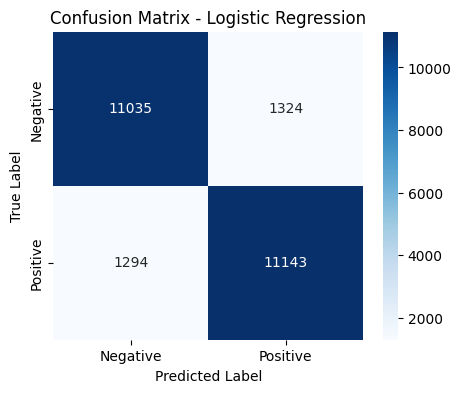


Training Linear SVC...
              precision    recall  f1-score   support

           0     0.8819    0.8897    0.8858     12359
           1     0.8894    0.8816    0.8855     12437

    accuracy                         0.8857     24796
   macro avg     0.8857    0.8857    0.8857     24796
weighted avg     0.8857    0.8857    0.8857     24796



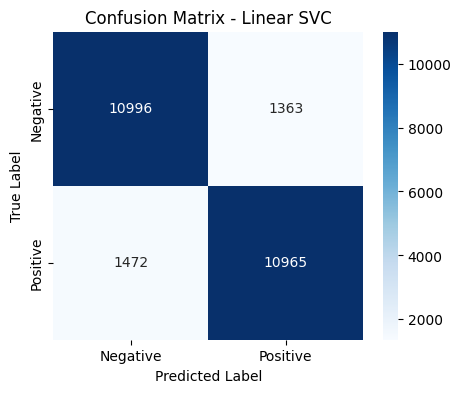


Training Random Forest...
              precision    recall  f1-score   support

           0     0.8550    0.8684    0.8617     12359
           1     0.8672    0.8537    0.8604     12437

    accuracy                         0.8610     24796
   macro avg     0.8611    0.8610    0.8610     24796
weighted avg     0.8611    0.8610    0.8610     24796



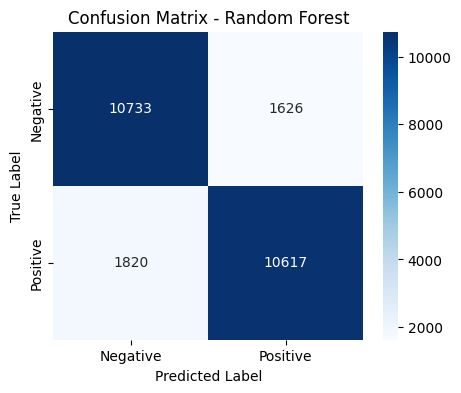


Model Comparison:
                  Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.894418   0.893800  0.895956  0.894876
1           Linear SVC  0.885667   0.889439  0.881643  0.885524
2        Random Forest  0.861026   0.867189  0.853662  0.860373


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# After your results loop
results = [] # Clear the results list to avoid duplicate entries
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    acc  = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec  = recall_score(y_test, preds)
    f1   = f1_score(y_test, preds)
    results.append([name, acc, prec, rec, f1])

    # Classification report
    reports[name] = classification_report(y_test, preds, digits=4)
    print(reports[name])

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Results table
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"]).sort_values("F1", ascending=False)
print("\nModel Comparison:\n", results_df)

/tmp/ipython-input-801122118.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


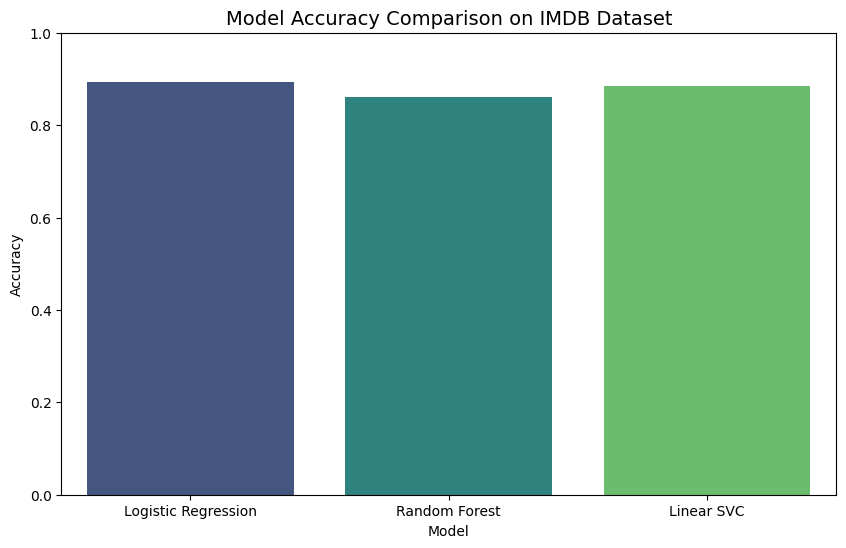


Model Performance Metrics:
                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.894418   0.894420  0.894418  0.894418
1        Random Forest  0.861026   0.861121  0.861026  0.861021
2           Linear SVC  0.885667   0.885700  0.885667  0.885666


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use the cleaned text and TF-IDF transformed data from the previous step
# X_train and X_test are already defined and transformed in the previous cell
# y_train and y_test are also defined

# ==============================
# Train example models
# ==============================

# Define the models with the same parameters as the previous successful cell
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1, solver='lbfgs', C=2.0),
    "Linear SVC":          LinearSVC(C=1.0),
    "Random Forest":       RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=42)
}

log_reg_model = models["Logistic Regression"]
log_reg_model.fit(X_train, y_train)

rf_model = models["Random Forest"]
rf_model.fit(X_train, y_train)

svc_model = models["Linear SVC"]
svc_model.fit(X_train, y_train)

# ==============================
# Evaluate models and store results
# ==============================
results = []

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})

# Use the trained models and the correct test data
evaluate_model("Logistic Regression", log_reg_model, X_test, y_test)
evaluate_model("Random Forest", rf_model, X_test, y_test)
evaluate_model("Linear SVC", svc_model, X_test, y_test)

# ==============================
# Plot model comparison
# ==============================
results_df = pd.DataFrame(results)
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison on IMDB Dataset", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Show full metric table
print("\nModel Performance Metrics:")
print(results_df)